In [1]:
import gzip
from pathlib import Path

In [2]:
import h5py
import numpy as np
from sklearn.metrics import matthews_corrcoef, accuracy_score, roc_auc_score, roc_curve, auc, precision_recall_curve, confusion_matrix
from scipy.stats.stats import pearsonr
from matplotlib import pyplot as plt

In [3]:
#BASE_DIR = Path("/mnt/g/My Drive/CloudVault/Masters/Data")
BASE_DIR = Path("/home/jakob/Cloudvault_new/Data")

# Path of directory to get Graphpart output
GRAPHPART_DIR = BASE_DIR/'NetOGlyc5 data'/'GalNAc data'/'06-partitioning'/'graphpart_partitions'

# Paths of imported embeddings file
EMBEDDING_FILE = BASE_DIR/'NetOGlyc5 data'/'GalNAc data'/'05-embedding'/'protein_embeddings_netsurfp_output_glyc_labels_max.h5'

# Maximum sequence length of proteins for test set
#MAX_SEQ_LENGTH = 1022
MAX_SEQ_LENGTH = 34350

IGNORE_MISSING_IDS = True

In [4]:
GRAPHPART_OUTPUT_FILE = GRAPHPART_DIR/'graphpart_output.csv'

In [5]:
clusters = [set(), set(), set()]
with open(GRAPHPART_OUTPUT_FILE, 'r') as f:
    f_iter = iter(f)
    header = next(f_iter).strip().split(',')
    for line in f_iter:
        AC, priority, glycosylated, cluster = line.strip().split(',')
        priority = priority == "True"
        glycosylated = float(glycosylated) > 0
        cluster = int(float(cluster))
        clusters[cluster].add(AC)

testing_ids = clusters[2]

len(testing_ids)

267

In [6]:
with h5py.File(EMBEDDING_FILE, 'r') as file:
    identifiers_list = file['identifiers'].asstr()[:].tolist()
    sequences_list = file['sequences'].asstr()[:].tolist()
    seq_lengths = [len(seq) for seq in sequences_list]
    gly = file['labels']['gly'][:, :MAX_SEQ_LENGTH, 0]

In [7]:
missing_embedding_identifiers = set(testing_ids) - set(identifiers_list)
if len(missing_embedding_identifiers) > 0:
    if not IGNORE_MISSING_IDS:
        raise Exception(f"{len(missing_embedding_identifiers)} test identifiers not found in embeddings: {missing_embedding_identifiers}")
        
if len(missing_embedding_identifiers) > 0:
    print(f"Ignoring following {len(missing_embedding_identifiers)} missing test identifiers: {missing_embedding_identifiers}")

testing_scores = testing_ids - missing_embedding_identifiers

In [8]:
all_labels = []

unambiguous_labels = []

for identifier in testing_scores:
    embedding_idx = identifiers_list.index(identifier)
    seq_length = min(len(sequences_list[embedding_idx]), MAX_SEQ_LENGTH)
    
    labels = gly[embedding_idx, :seq_length]
    site_mask = (labels >= 0)
    unambiguous_site_mask = (labels == 0) | (labels == 1)
       
    all_labels.append(labels[site_mask])
    
    unambiguous_labels.append(labels[unambiguous_site_mask])

all_labels = np.concatenate(all_labels)

unambiguous_labels = np.concatenate(unambiguous_labels)

In [9]:
baseline_all_pred_value = np.mean(all_labels)
baseline_unambiguous_pred_value = np.mean(unambiguous_labels)

all_pred = np.full(all_labels.shape, baseline_all_pred_value)
unambiguous_pred = np.full(unambiguous_labels.shape, baseline_unambiguous_pred_value)


print(f"Baseline prediction value for all sites: {baseline_all_pred_value}")
print(f"Baseline prediction value for unambiguous sites: {baseline_unambiguous_pred_value}")

Baseline prediction value for all sites: 0.2801949679851532
Baseline prediction value for unambiguous sites: 0.2775140404701233


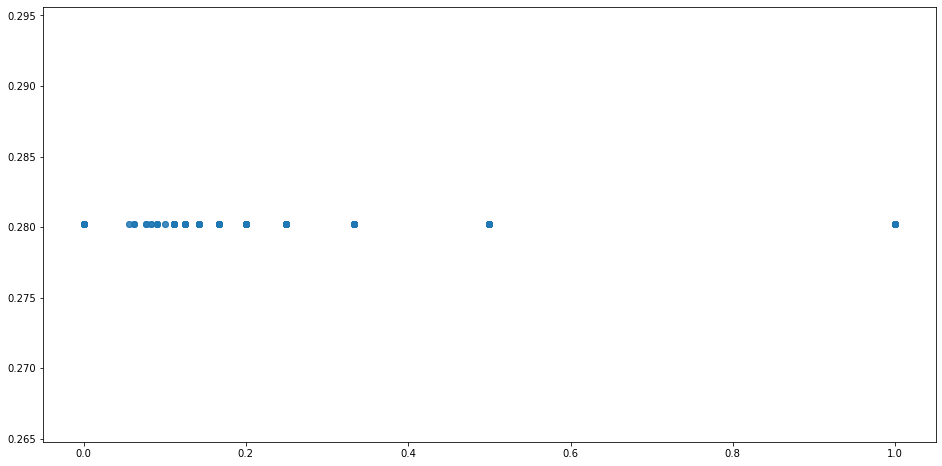

In [10]:
plt.figure(figsize=(16, 8))
plt.scatter(all_labels, all_pred, alpha=0.2)

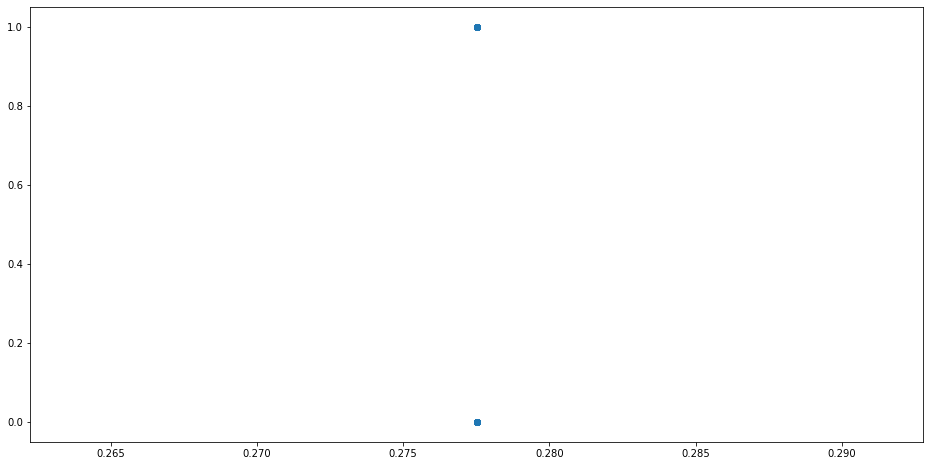

In [11]:
plt.figure(figsize=(16, 8))
plt.scatter(unambiguous_pred, unambiguous_labels, alpha=0.2)

In [12]:
def plot_roc_curve(labels, pred, title="Receiver operating characteristic"):
    fpr, tpr, _ = roc_curve(labels, pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    lw = 2
    plt.plot(
        fpr,
        tpr,
        color="darkorange",
        lw=lw,
        label="ROC curve (area = %0.2f)" % roc_auc,
    )
    plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

def calculate_metrics(all_labels, all_pred, unambiguous_labels, unambiguous_pred, all_labels_threshold=0.5, pred_threshold=0.5):
    print(f"% of unambiguous sites glycosylated: {(unambiguous_labels > 0).sum() / len(unambiguous_labels) * 100}")
    print(f"Accuracy for unambiguous sites: {accuracy_score(unambiguous_labels, (unambiguous_pred >= pred_threshold))}")
    print(f"MCC for unambiguous sites: {matthews_corrcoef(unambiguous_labels, (unambiguous_pred >= pred_threshold))}")
    print(f"PCC for unambiguous sites: {pearsonr(unambiguous_pred, unambiguous_labels)}")
    print(f"ROC-AUC for unambiguous sites: {roc_auc_score(unambiguous_labels, unambiguous_pred)}")
    
    tn, fp, fn, tp = confusion_matrix(unambiguous_labels, (unambiguous_pred >= pred_threshold)).ravel()
    sensitivity = tp / (tp+fn)
    specificity = tn / (tn+fp)
    print(f"Sensitivity (TPR) for unambiguous sites: {sensitivity*100:.2f}%")
    print(f"Specificity (TNR) for unambiguous sites: {specificity*100:.2f}%")
    
    plot_roc_curve(unambiguous_labels, unambiguous_pred, "Receiver operating characteristic for unambiguous sites")
    
    print(f"% of all sites glycosylated: {(all_labels > 0).sum() / len(all_labels) * 100}")
    print(f"Accuracy for all sites (threshold 0.5): {accuracy_score((all_labels >= all_labels_threshold), (all_pred >= pred_threshold))}")
    print(f"MCC for all sites (threshold 0.5): {matthews_corrcoef((all_labels >= all_labels_threshold), (all_pred >= pred_threshold))}")
    print(f"PCC for all sites: {pearsonr(all_pred, all_labels)}")
    print(f"ROC-AUC for all sites (threshold 0.5): {roc_auc_score((all_labels >= all_labels_threshold), all_pred)}")

    tn, fp, fn, tp = confusion_matrix((all_labels >= all_labels_threshold), (all_pred >= pred_threshold)).ravel()
    sensitivity = tp / (tp+fn)
    specificity = tn / (tn+fp)
    print(f"Sensitivity (TPR) for all sites (threshold 0.5): {sensitivity*100:.2f}%")
    print(f"Specificity (TNR) for all sites (threshold 0.5): {specificity*100:.2f}%")
    
    plot_roc_curve((all_labels >= all_labels_threshold), all_pred, "Receiver operating characteristic for all sites (threshold 0.5)")

Baseline predictions for test partition of NetOGlyc-5.0 'max' dataset (5911 sites, 4634 unambiguous sites):

% of unambiguous sites glycosylated: 27.751402675873976
Accuracy for unambiguous sites: 0.7224859732412603
MCC for unambiguous sites: 0.0
PCC for unambiguous sites: (nan, nan)
ROC-AUC for unambiguous sites: 0.5
Sensitivity (TPR) for unambiguous sites: 0.00%
Specificity (TNR) for unambiguous sites: 100.00%


/home/jakob/miniconda3/envs/nog5/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


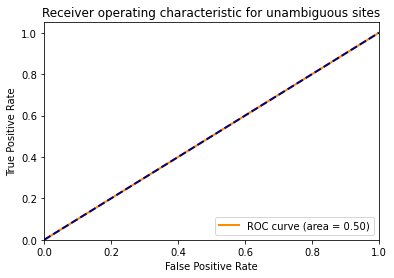

% of all sites glycosylated: 43.35983759093216
Accuracy for all sites (threshold 0.5): 0.7321942141769582
MCC for all sites (threshold 0.5): 0.0
PCC for all sites: (nan, nan)
ROC-AUC for all sites (threshold 0.5): 0.5
Sensitivity (TPR) for all sites (threshold 0.5): 0.00%
Specificity (TNR) for all sites (threshold 0.5): 100.00%


/home/jakob/miniconda3/envs/nog5/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


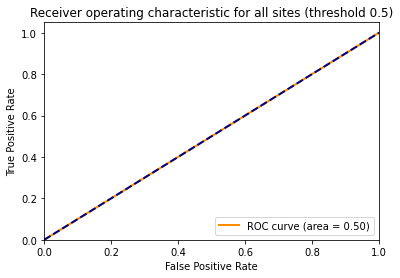

In [13]:
print(f"Baseline predictions for test partition of NetOGlyc-5.0 'max' dataset ({len(all_labels)} sites, {len(unambiguous_labels)} unambiguous sites):\n")
calculate_metrics(all_labels, all_pred, unambiguous_labels, unambiguous_pred, all_labels_threshold=0.5, pred_threshold=0.5)